# Part 1: Understanding Convlutions

## Step 0: Some import and later required functions

In [2]:
# Imports
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import mnist
from matplotlib import pyplot as plt
import matplotlib as mpl

# Set a seed for reproducibility
seed = 42
random.seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

## Convolutional Filters

### 
Given the input matrix I and filter J shown below, compute I ∗ J, the output of the convolution operation (as defined in lecture). Assume zero padding is used such that the input and output are of the same dimension. What feature does this convolutional filter detect?
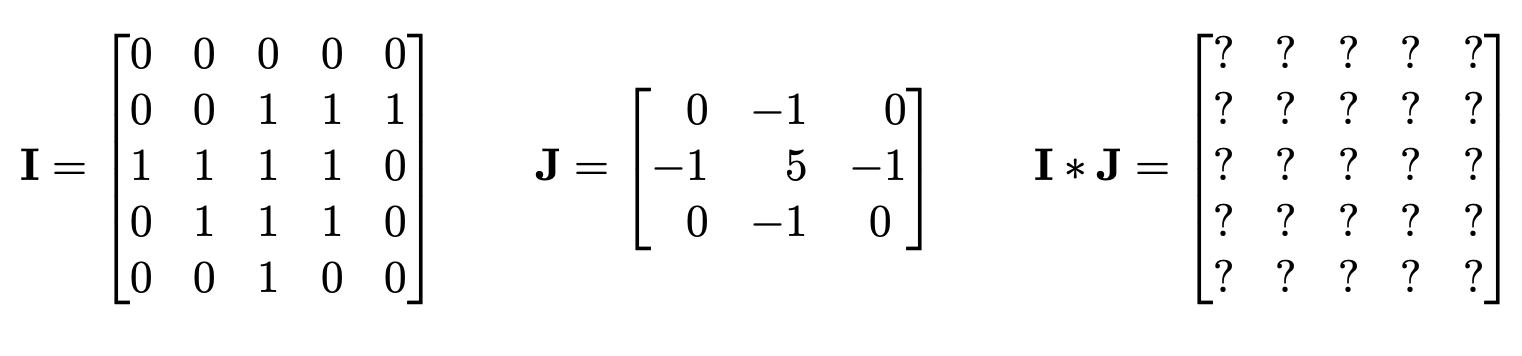

In [3]:
#!pip install mnist

# Training CNN with Skip Connection and Batch Normalization

The MNIST dataset is a collection of handwritten digits commonly used for training and testing in the field of machine learning. We want to normalize data and create randomized batches for training and evaluation. It consists of 60,000 images for training and 10,000 images for testing. Each image is 28*28 pixels.


In [118]:
# ------------------------------
# Data Preparation
# ------------------------------

# Set the MNIST datasets URL.
mnist.datasets_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

# Load the labels and images.
train_labels = mnist.train_labels()
test_labels = mnist.test_labels()
scale_mean, scale_std = mnist.train_images().mean(), mnist.train_images().std()
train_images = (mnist.train_images() - scale_mean) / scale_std
test_images = (mnist.test_images() - scale_mean) / scale_std

# Convert the data to PyTorch tensors and add a channel dimension.
train_data = torch.FloatTensor(train_images[:, None])  # Shape: (60000, 1, 28, 28)
train_targets = torch.LongTensor(train_labels)
test_data = torch.FloatTensor(test_images[:, None])    # Shape: (10000, 1, 28, 28)
test_targets = torch.LongTensor(test_labels)

# Create TensorDataset objects.
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)

# Create DataLoader objects.
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Integrating Skip Connections and Batch Normalization
In this exercise, you will modify the CNN that you designed for MNIST digit classification to include two technologies that created a huge leap in the performcne of Neural Netowrks

- **Skip Connections (Residual Blocks):** These allow the network to learn residual mappings by directly passing the input of a block to its output. Skip connections help alleviate the vanishing gradient problem, making it easier to train deeper networks.
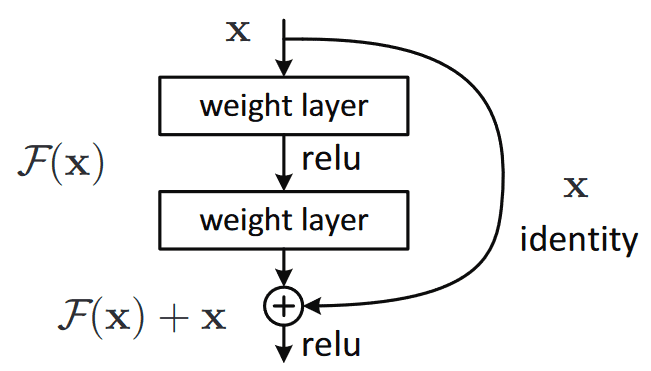

- **Batch Normalization:** This technique normalizes the output of a layer to speed up training and improve stability. 

**Question:** In our exercise, batch normalization will be applied after each convolution before the non-linearity. Why not after the non-linearity?

### Detailed Instructions
You will build a network that first processes the image with an initial convolution layer, then uses a residual block (or blocks) to process the features, and finally applies a fully connected layer for classification. Make sure to compute the proper dimensions when designing the fully connected layer after the convolutional and pooling operations.

1. **Define a Residual Block:**
   - Create a custom PyTorch module called `ResidualBlock` that:
     - Contains two convolutional layers with 3×3 kernels (with appropriate padding to keep the spatial dimensions).
     - Applies batch normalization after each convolution.
     - Uses a ReLU activation after the first batch normalization.
     - Includes a skip connection that adds the (possibly projected) input to the block’s output. If the number of input channels differs from the number of output channels, use a 1×1 convolution (with its own batch normalization) to match dimensions.
   - **Hint:** If the number of channels in the input and output are the same, the skip connection can simply be the identity mapping.

2. **Construct the CNN Network:**
   - Start with an initial convolutional layer that expands the MNIST image (1 channel) to a higher number (e.g., 16 channels). Apply batch normalization and ReLU.
   - Apply a 2×2 max-pooling layer to reduce the spatial dimensions.
   - Insert one or two `ResidualBlock`s:
     - The first block can keep the channel count the same (e.g., 16→16).
     - The second block can increase the number of channels (e.g., 16→32).
   - Optionally, include another pooling layer after the residual blocks to further reduce the dimensions.
   - After the convolutional/residual parts, flatten the output (keeping the batch dimension) and then pass it through the final fully connected layer to output the class scores (10 classes for MNIST).
   - **Important:** Compute the flattened feature size after these operations, as this determines the input dimension of your final fully connected (classification) layer.



### Guidance and Key Points

- **Skip Connections:** Notice how the `ResidualBlock` adds the original (or projected) input back to the output before applying the final ReLU activation. This is a key design element in modern networks like ResNets.
- **Batch Normalization:** Batch normalization layers (`nn.BatchNorm2d`) are inserted immediately after the convolutions. This helps normalize the activations, which can lead to faster convergence and improved performance.
- **1x1 Convolutions:** In scenarios where the number of input channels does not match the number of output channels in a residual block, a 1x1 convolution is used to project the input to the correct dimensions. This projection ensures that the skip connection (which adds the input to the output) is valid by matching the channel dimensions. Additionally, 1x1 convolutions are efficient and can help reduce the number of parameters, lowering computational costs without sacrificing the network’s ability to capture important features.

In [ ]:
# ------------------------------
# Residual Block with Batch Normalization
# ------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        # TODO: Define the first convolutional layer with kernel_size=3 and padding=1.
        self.conv1 = ...
        # TODO: Define batch normalization for the first convolution.
        self.bn1 = ...
        
        # TODO: Define the second convolutional layer with kernel_size=3 and padding=1.
        self.conv2 = ...
        # TODO: Define batch normalization for the second convolution.
        self.bn2 = ...
        
        # If the input and output channels are different, create a projection for the shortcut.
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                # TODO: Define a 1x1 convolution to project the input to the correct channel size.
                ...,
                # TODO: Define batch normalization for the projection.
                ...
            )
        else:
            # If channels match, use identity mapping.
            self.shortcut = nn.Identity()

    def forward(self, x):
        # ------------------------------
        # TODO: Write the forward pass for the Residual Block.
        # 1. Compute the identity branch
        # 2. Process x through the first convolution, batch norm, and ReLU.
        # 3. Process the result through the second convolution and batch norm.
        # 4. Add the identity to the output from step 3.
        # 5. Apply a ReLU activation to the summed output and return it.
        # ------------------------------
        ...
        return out

# ------------------------------
# CNN with Skip Connections and Batch Normalization
# ------------------------------
class ResNetCNN(nn.Module):
    def __init__(self):
        super(ResNetCNN, self).__init__()
        
        # TODO: Define the initial convolution layer that maps input from 1 channel to 16 channels.
        self.initial_conv = ...
        # TODO: Define batch normalization for the initial layer.
        self.initial_bn = ...
        
        # TODO: Define a pooling layer (max) to reduce spatial dimensions by a factor of 2
        self.pool = ...
        
        # TODO: Add the first residual block (keeping 16 channels).
        self.resblock1 = ...
        # TODO: Add the second residual block (increasing channels from 16 to 32).
        self.resblock2 = ...
        
        
        # TODO: Calculate the flattened feature size.
        flattened_size = ...
        
        # TODO: Define the fully connected layer to map from flattened_size to 10 classes.
        self.fc = ...

    def forward(self, x):
        # ------------------------------
        # TODO: Write the forward pass.
        # 1. Initial convolution, batch norm, and activation and pooling
        # 2. Pass through the first and second residual block.
        # 3. Flatten the output while preserving the batch dimension.
        # 4. Apply the classification head.
        # ------------------------------
        ...
        return x



### Implementing a Training/Test Loop in PyTorch on MNIST

### Objective
Design a basic train and test loop for your neural network model. Compare the test results on your new model (ResNetCNN) with the one we had in the tutorial (myCNN). You can use the full dataset (60000 images) for training and (10000 images) testing. Print or plot the results for comparison.


In [1]:
# ------------------------------
# Define Training and Evaluation Functions
# ------------------------------

def train(model, optimizer, criterion, train_loader):
    model.train()  # Set the model to training mode.
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ... # TODO: Zero the gradients for the optimizer.
        
        # TODO: Forward pass: compute model output for the inputs.
        ...
        
        # TODO: Compute the loss using the provided criterion.
        ...
        
        # TODO: Backward pass: compute gradients of the loss w.r.t. model parameters.
        ...
        
        # TODO: Update the model parameters.
        ...
        
        # Accumulate metrics.
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, criterion, test_loader):
    model.eval()  # Set the model to evaluation mode.
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            # TODO: Forward pass: compute model output for the inputs.
            ...
            
            # TODO: Compute the loss for this batch.
            ...
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# ------------------------------
# Training Loop to Compare Two Models
# ------------------------------

# TODO: define your two models: myCNN (from tutorial) and ResNetCNN.
old_model = ...
resnet_model = ...

# Set up the loss criterion and optimizers for both models.
criterion = nn.CrossEntropyLoss()
optimizer_my_model = optim.Adam(my_model.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

num_epochs = 100  # You can adjust the number of epochs.

# Training loop for both models.
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train baseline model.
    train_loss_my, train_acc_my = train(my_model, optimizer_my_model, criterion, train_loader)
    test_loss_my, test_acc_my = evaluate(my_model, criterion, test_loader)
    print(f"[myCNN] Train Loss: {train_loss_my:.4f} | Train Acc: {train_acc_my:.2f}% | Test Loss: {test_loss_my:.4f} | Test Acc: {test_acc_my:.2f}%")
    
    # Train ResNet model.
    train_loss_res, train_acc_res = train(resnet_model, optimizer_resnet, criterion, train_loader)
    test_loss_res, test_acc_res = evaluate(resnet_model, criterion, test_loader)
    print(f"[ResNetCNN] Train Loss: {train_loss_res:.4f} | Train Acc: {train_acc_res:.2f}% | Test Loss: {test_loss_res:.4f} | Test Acc: {test_acc_res:.2f}%")

# ------------------------------
# Final Evaluation and Comparison
# ------------------------------

print("\nFinal Evaluation on Test Data:")
final_loss_my, final_acc_my = evaluate(my_model, criterion, test_loader)
final_loss_res, final_acc_res = evaluate(resnet_model, criterion, test_loader)

print(f"myCNN: Test Loss = {final_loss_my:.4f}, Test Accuracy = {final_acc_my:.2f}%")
print(f"ResNetCNN: Test Loss = {final_loss_res:.4f}, Test Accuracy = {final_acc_res:.2f}%")
